# Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones
## Programación Distribuida sobre Grandes Volúmenes de Datos

Damián Barsotti 

### Facultad de Matemática Astronomía Física y Computación
## Universidad Nacional de Córdoba

<img src="http://program.ar/wp-content/uploads/2018/07/logo-UNC-FAMAF.png" alt="Drawing" style="width:80%;"/>

### Antes de comenzar
#### En máquina virtual
1. Lanzar terminal
1. Actualizar repo:
```sh
cd diplodatos_bigdata
git pull
```
1. Lanzar [Zeppelin](http://zeppelin.apache.org/):
```sh
cd
cd spark/zeppelin-0.8.2-bin-all
./bin/zeppelin-daemon.sh start
```
1. En navegador abrir [http://localhost:8080](http://localhost:8080)
1. Seleccionar `Import note`
1. Elegir json en `diplodatos_bigdata/clases/04_dataframes_tablas/note.json`
2. Seleccionar `Clase 04 - Dataframes y Tablas`

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.appName("04_dataframes_tablas").getOrCreate()
sc = spark.sparkContext

## Dataframes y Tablas (ejemplo)

In [3]:
flightsInDF = spark.read.load("../inputs/ds/flights.csv",
                    format="csv", delimiter=",", header=True, inferSchema=True)
flightsInDF.count()

100000

In [4]:
flightsInDF.limit(10)

DataFrame[Year: int, Month: int, DayofMonth: int, DayOfWeek: int, DepTime: string, CRSDepTime: int, ArrTime: string, CRSArrTime: int, UniqueCarrier: string, FlightNum: int, TailNum: string, ActualElapsedTime: string, CRSElapsedTime: int, AirTime: string, ArrDelay: string, DepDelay: string, Origin: string, Dest: string, Distance: int, TaxiIn: string, TaxiOut: string, Cancelled: int, CancellationCode: string, Diverted: int, CarrierDelay: string, WeatherDelay: string, NASDelay: string, SecurityDelay: string, LateAircraftDelay: string]

#### Descripción de columnas
##### Algunas columnas importantes

In [5]:
flightsInDF.select("UniqueCarrier", "FlightNum", "DepDelay", "ArrDelay", "Distance").show()

+-------------+---------+--------+--------+--------+
|UniqueCarrier|FlightNum|DepDelay|ArrDelay|Distance|
+-------------+---------+--------+--------+--------+
|           WN|      335|       8|     -14|     810|
|           WN|     3231|      19|       2|     810|
|           WN|      448|       8|      14|     515|
|           WN|     1746|      -4|      -6|     515|
|           WN|     3920|      34|      34|     515|
|           WN|      378|      25|      11|     688|
|           WN|      509|      67|      57|    1591|
|           WN|      535|      -1|     -18|    1591|
|           WN|       11|       2|       2|     451|
|           WN|      810|       0|     -16|     451|
|           WN|      100|       6|       1|     828|
|           WN|     1333|      94|      80|     828|
|           WN|      829|      -4|       1|     162|
|           WN|     1016|       0|      10|     162|
|           WN|     1827|       2|      -4|     162|
|           WN|     2272|       9|      11|   

#### Esquema

In [6]:
flightsInDF.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: string (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- ArrTime: string (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: string (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: string (nullable = true)
 |-- DepDelay: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiIn: string (nullable = true)
 |-- TaxiOut: string (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: integer (nullable = true)
 |-- Ca

Vuelos retrasados (> 15')

In [7]:
delayedDF = flightsInDF.select("UniqueCarrier", "DepDelay").filter("DepDelay > 15").cache()
delayedDF.show(n=5)

+-------------+--------+
|UniqueCarrier|DepDelay|
+-------------+--------+
|           WN|      19|
|           WN|      34|
|           WN|      25|
|           WN|      67|
|           WN|      94|
+-------------+--------+
only showing top 5 rows



Cantidad

In [8]:
print("Cantidad de vuelos retrasados por más de 15': ", delayedDF.count())

Cantidad de vuelos retrasados por más de 15':  19587


### User Defined Functions (UDF)

In [9]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

#* Función que define si un vuelo está retrasado
#* Si el retraso es > que 15' devuelve 1
#* si no 0
#* Si no está definida devuelve 0
# ********************************************************/

def isDelayed(time):
    if time == "NA":
        return 0 
    elif int(time) > 15: 
        return 1 
    else:
        return 0

# UDF que define si un vuelo está retrasado

isDelayedUDF = udf(isDelayed, IntegerType())

### Nuevo Dataframe usando UDF
Nuevo Dataframe con algunas columnas y con una nueva indicando si el vuelo está retrasado

In [10]:
flightsDF = flightsInDF.select(
    "Year", "Month", "DayofMonth", "DayOfWeek", "CRSDepTime", "UniqueCarrier", "FlightNum", 
    "DepDelay", "ArrDelay", "Origin", "Dest", "TaxiIn", "TaxiOut", "Distance",
    isDelayedUDF("DepDelay").alias("IsDepDelayed")).cache()

flightsDF.toPandas()

,Year,Month,DayofMonth,DayOfWeek,CRSDepTime,UniqueCarrier,FlightNum,DepDelay,ArrDelay,Origin,Dest,TaxiIn,TaxiOut,Distance,IsDepDelayed
0,2008,1,3,4,1955,WN,335,8,-14,IAD,TPA,4,8,810,0
1,2008,1,3,4,735,WN,3231,19,2,IAD,TPA,5,10,810,1
2,2008,1,3,4,620,WN,448,8,14,IND,BWI,3,17,515,0
3,2008,1,3,4,930,WN,1746,-4,-6,IND,BWI,3,7,515,0
4,2008,1,3,4,1755,WN,3920,34,34,IND,BWI,3,10,515,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2008,1,25,5,1935,XE,7676,149,129,SLC,OKC,4,17,866,1
99996,2008,1,26,6,1935,XE,7676,-2,-23,SLC,OKC,4,16,866,0
99997,2008,1,27,7,1935,XE,7676,72,63,SLC,OKC,6,18,866,1
99998,2008,1,28,1,1935,XE,7676,21,11,SLC,OKC,5,25,866,1


Porcentaje de vuelos demorados

In [11]:
from pyspark.sql.functions import sum, count

percDelayedDF = flightsDF.agg(
    (sum("IsDepDelayed") * 100 / count("*"))\
    .alias("Porcentaje de vuelos retrasados"))\
    .cache()


firstRow = percDelayedDF.first()

porcentaje = firstRow.asDict()["Porcentaje de vuelos retrasados"]

print(f"Porcentaje de vuelos demorados: {porcentaje}%")

Porcentaje de vuelos demorados: 19.587%


Promedio de Taxi-out

### Ejercicio
Averiguar el promedio de Taxi-in por origen y destino.

In [12]:
from pyspark.sql.functions import avg

promTODF= flightsDF.select("Origin", "Dest", "TaxiOut") \
         .groupBy("Origin", "Dest").agg(avg("TaxiOut").alias("AvgTaxiOut")) \
         .orderBy("AvgTaxiOut", ascending=False)

promTODF.show()

+------+----+------------------+
|Origin|Dest|        AvgTaxiOut|
+------+----+------------------+
|   LCH| IAH|              84.0|
|   EWR| BHM|              63.0|
|   EWR| SDF|              45.0|
|   EWR| GSO|              36.5|
|   MHT| CLE|              33.0|
|   EWR| JAX|              28.0|
|   CLE| SDF|              27.0|
|   EWR| DTW|              27.0|
|   ORD| EWR|              26.0|
|   EWR| MCI|              26.0|
|   PHL| JAX| 24.11111111111111|
|   SLC| OKC|             23.45|
|   SLC| EUG|23.423076923076923|
|   TUL| SMF|22.413793103448278|
|   CLE| BUF|              21.0|
|   DAY| IAH|              21.0|
|   LAS| OKC|20.586206896551722|
|   COS| SAN|20.220338983050848|
|   LAS| MHT| 20.06896551724138|
|   IAH| BNA|              20.0|
+------+----+------------------+
only showing top 20 rows



## SQL Plano
---

Creacion de tabla temporal

In [13]:
flightsDF.createOrReplaceTempView("flightsTbl")

Tabla vuelos

In [14]:
resDF = spark.sql("SELECT * FROM flightsTbl LIMIT 10")
resDF.toPandas()

,Year,Month,DayofMonth,DayOfWeek,CRSDepTime,UniqueCarrier,FlightNum,DepDelay,ArrDelay,Origin,Dest,TaxiIn,TaxiOut,Distance,IsDepDelayed
0,2008,1,3,4,1955,WN,335,8,-14,IAD,TPA,4,8,810,0
1,2008,1,3,4,735,WN,3231,19,2,IAD,TPA,5,10,810,1
2,2008,1,3,4,620,WN,448,8,14,IND,BWI,3,17,515,0
3,2008,1,3,4,930,WN,1746,-4,-6,IND,BWI,3,7,515,0
4,2008,1,3,4,1755,WN,3920,34,34,IND,BWI,3,10,515,1
5,2008,1,3,4,1915,WN,378,25,11,IND,JAX,4,10,688,1
6,2008,1,3,4,1830,WN,509,67,57,IND,LAS,3,7,1591,1
7,2008,1,3,4,1040,WN,535,-1,-18,IND,LAS,7,7,1591,0
8,2008,1,3,4,615,WN,11,2,2,IND,MCI,6,19,451,0
9,2008,1,3,4,1620,WN,810,0,-16,IND,MCI,3,6,451,0


#### UDF en SQL plano

`isDelayed`  ya la definimos
 Registración de UDF para usar con tablas

In [15]:
spark.udf.register("isDelayedTabUDF", isDelayed)

<function __main__.isDelayed(time)>

Usando Sql
```sql
SELECT UniqueCarrier, SUM(isDelayedTabUDF(ArrDelay)) AS NumArrDelays 
FROM flightsTbl GROUP BY UniqueCarrier
```

```sql
SELECT UniqueCarrier, AVG(ArrDelay) AS AvgTimeDelay 
FROM flightsTbl WHERE isDelayedTabUDF(ArrDelay) == 1 
GROUP BY UniqueCarrier 
```

SQL programatico

In [16]:
flightsDF.filter(isDelayedUDF("ArrDelay") == 1) \
    .groupBy("UniqueCarrier") \
    .agg(avg("ArrDelay")) \
    .show()

+-------------+-----------------+
|UniqueCarrier|    avg(ArrDelay)|
+-------------+-----------------+
|           XE|60.71565802113353|
|           WN|50.37351433560525|
+-------------+-----------------+



### Ejereccio

Encontrar la distancia de vuelo promedio por empresa.

In [17]:
flightsDF.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- DepDelay: string (nullable = true)
 |-- ArrDelay: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- TaxiIn: string (nullable = true)
 |-- TaxiOut: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- IsDepDelayed: integer (nullable = true)



In [18]:
flightsDF.select("UniqueCarrier", "Distance")\
    .groupBy("UniqueCarrier") \
    .agg(avg("Distance")) \
    .show()

+-------------+-----------------+
|UniqueCarrier|    avg(Distance)|
+-------------+-----------------+
|           XE|738.0677880571909|
|           WN|623.7926638668864|
+-------------+-----------------+



### Ejercicio
Retrasados y en horario por día de la semana

In [19]:
from pyspark.sql.functions import when

retardos = flightsDF.select(
    "DayOfWeek", when(isDelayedUDF("ArrDelay") == 1, 'delayed').otherwise('ok')\
    .alias('Delay'))\
    .groupBy("DayOfWeek", 'Delay')\
    .agg(count("*")).alias("count")

retardos.show()

+---------+-------+--------+
|DayOfWeek|  Delay|count(1)|
+---------+-------+--------+
|        1|     ok|   11915|
|        5|     ok|   11187|
|        5|delayed|    3330|
|        6|delayed|    1792|
|        2|delayed|    1711|
|        6|     ok|    9493|
|        1|delayed|    2604|
|        3|     ok|   13350|
|        4|delayed|    4706|
|        4|     ok|   12373|
|        3|delayed|    1344|
|        2|     ok|   12999|
|        7|     ok|    9889|
|        7|delayed|    3307|
+---------+-------+--------+



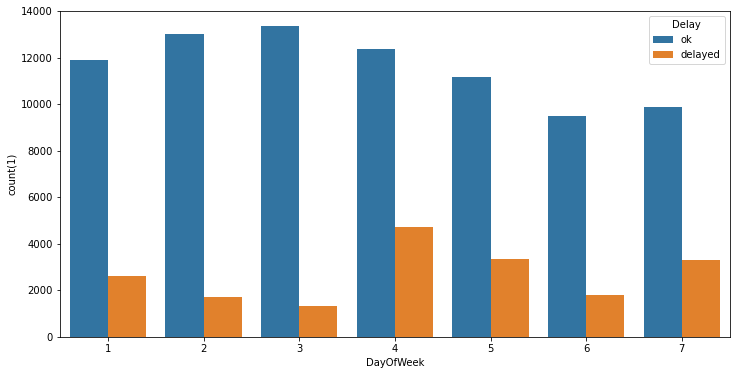

In [26]:
plt.figure(figsize=(12, 6))
sns.barplot(x='DayOfWeek',y='count(1)', hue='Delay', data=retardos.toPandas())
plt.show()

### Ejercicio

Retrasados y en horario por hora

In [ ]:
SELECT CAST(CRSDepTime / 100 AS INT) AS Hour, CASE WHEN isDelayedTabUDF(DepDelay) = 1 THEN 'delayed' ELSE 'ok' END AS Delay, COUNT(1) AS Count
FROM flightsTbl
GROUP BY Hour, Delay
ORDER BY Hour

In [34]:
retardos = flightsDF.select(
    (flightsDF.CRSDepTime / 100).cast("int").alias("Hour"),
    when(isDelayedUDF("ArrDelay") == 1, 'delayed').otherwise('ok')\
    .alias('Delay'))\
    .groupBy("Hour", 'Delay')\
    .agg(count("*")).alias("count")

retardos.show()

+----+-------+--------+
|Hour|  Delay|count(1)|
+----+-------+--------+
|  12|     ok|    5191|
|  13|     ok|    5327|
|  20|delayed|    1551|
|  10|     ok|    5784|
|  19|     ok|    4656|
|  15|     ok|    4966|
|  15|delayed|    1414|
|  21|     ok|    2386|
|   8|     ok|    5875|
|  12|delayed|    1111|
|  20|     ok|    3659|
|  10|delayed|     902|
|   9|delayed|     779|
|   6|delayed|     333|
|   6|     ok|    6001|
|  16|delayed|    1616|
|  21|delayed|    1094|
|  13|delayed|    1244|
|  18|delayed|    1790|
|  22|     ok|     215|
+----+-------+--------+
only showing top 20 rows



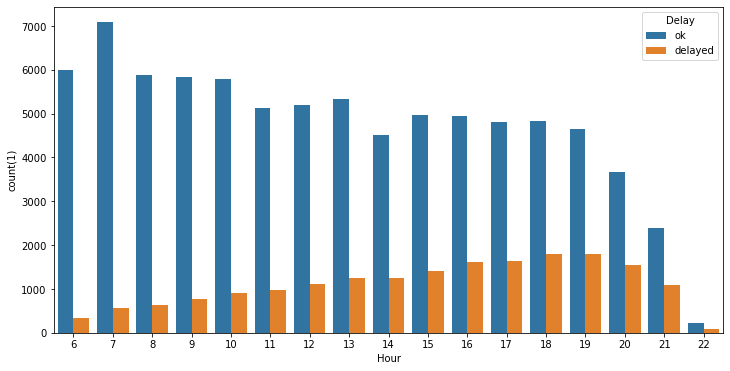

In [35]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Hour',y='count(1)', hue='Delay', data=retardos.toPandas())
plt.show()

## Lectura/Escritura
---
Guardar como archivo Orc


|Modo|  Significado|
|----|-------------|
|<code>"error"</code> (default) | Si existe se genera una excepción.|
| <code>"append"</code> | Si existe se agrega al final.|
| <code>"overwrite"</code> | Si existe se borra y se crea una nueva.|
|<code>"ignore"</code> | Si existe no se guarda. Similar a CREATE TABLE IF NOT.|


Cargar los datos usando `orc`

``` python 
testDF = spark.read.format("orc").load("flights.orc")
```

### Tablas permanentes

* `createOrReplaceTempView` crea **tablas** temporales (desaparecen cuando se destruye  `SparkSession`).
* `saveAsTable` 
    - guarda dataframes en *HiveMetastore* de forma permanente y
    - permita utilizar SQL plano sobre ella.
    
Guardad como tabla

In [39]:
flightsDF.write.format("orc").mode("overwrite").saveAsTable("lightsPermTbl")

### Leer tablas a Df


In [49]:
from pyspark.sql import SQLContext

In [52]:
sqlContext = SQLContext(sc)

dfFromTbl = sqlContext.table("flightstbl")

dfFromTbl.filter("IsDepDelayed == 1").toPandas()

,Year,Month,DayofMonth,DayOfWeek,CRSDepTime,UniqueCarrier,FlightNum,DepDelay,ArrDelay,Origin,Dest,TaxiIn,TaxiOut,Distance,IsDepDelayed
0,2008,1,3,4,735,WN,3231,19,2,IAD,TPA,5,10,810,1
1,2008,1,3,4,1755,WN,3920,34,34,IND,BWI,3,10,515,1
2,2008,1,3,4,1915,WN,378,25,11,IND,JAX,4,10,688,1
3,2008,1,3,4,1830,WN,509,67,57,IND,LAS,3,7,1591,1
4,2008,1,3,4,1510,WN,1333,94,80,IND,MCO,6,8,828,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19582,2008,1,17,4,1935,XE,7676,29,16,SLC,OKC,5,14,866,1
19583,2008,1,18,5,1935,XE,7676,41,47,SLC,OKC,4,35,866,1
19584,2008,1,25,5,1935,XE,7676,149,129,SLC,OKC,4,17,866,1
19585,2008,1,27,7,1935,XE,7676,72,63,SLC,OKC,6,18,866,1


### Ejercicio

Calcular la cantidad de vuelos que parten de cada aeropuerto y
guardar el resultado en una tabla permanente.

In [54]:
srcPort = dfFromTbl.select("Origin")\
        .groupBy("Origin")\
        .agg(count("*")).alias("count")

srcPort.show()

+------+--------+
|Origin|count(1)|
+------+--------+
|   MSY|    1282|
|   GEG|     673|
|   SNA|    1058|
|   BUR|    1613|
|   PVD|     951|
|   OAK|    3949|
|   ORF|     364|
|   CRW|       1|
|   CMH|     777|
|   IAH|       9|
|   SJC|    2197|
|   BUF|     464|
|   AUS|    1603|
|   LGB|     135|
|   BFL|      61|
|   RNO|    1272|
|   CHS|       1|
|   RSW|     319|
|   TUL|     695|
|   HRL|     310|
+------+--------+
only showing top 20 rows



#### Agregando nombres de empresas
en carriers.csv están los nombres

In [56]:
carriersDF = spark.read.load(
    "../inputs/ds/carriers.csv", format="csv", header=True, inferSchema=True)
carriersDF.show()

+----+--------------------+
|Code|         Description|
+----+--------------------+
| 02Q|       Titan Airways|
| 04Q|  Tradewind Aviation|
| 05Q| Comlux Aviation, AG|
| 06Q|Master Top Linhas...|
| 07Q| Flair Airlines Ltd.|
| 09Q|      Swift Air, LLC|
| 0BQ|                 DCA|
| 0CQ|ACM AIR CHARTER GmbH|
| 0FQ|Maine Aviation Ai...|
| 0GQ|Inter Island Airw...|
| 0HQ|Polar Airlines de...|
|  0J|          JetClub AG|
| 0JQ|     Vision Airlines|
| 0KQ|Mokulele Flight S...|
| 0LQ|   Metropix UK, LLP.|
| 0MQ|Multi-Aero, Inc. ...|
|  0Q| Flying Service N.V.|
|  16|   PSA Airlines Inc.|
|  17|   Piedmont Airlines|
|  1I|Sky Trek Int'l Ai...|
+----+--------------------+
only showing top 20 rows



#### join

In [58]:
from pyspark.sql.functions import col

flCarrDF = flightsDF.join(carriersDF, col("Code") == col("UniqueCarrier")) \
                .withColumnRenamed("Description","CarrierName")

print(flCarrDF.count())
flCarrDF.toPandas()

100000


,Year,Month,DayofMonth,DayOfWeek,CRSDepTime,UniqueCarrier,FlightNum,DepDelay,ArrDelay,Origin,Dest,TaxiIn,TaxiOut,Distance,IsDepDelayed,Code,CarrierName
0,2008,1,3,4,1955,WN,335,8,-14,IAD,TPA,4,8,810,0,WN,Southwest Airlines Co.
1,2008,1,3,4,735,WN,3231,19,2,IAD,TPA,5,10,810,1,WN,Southwest Airlines Co.
2,2008,1,3,4,620,WN,448,8,14,IND,BWI,3,17,515,0,WN,Southwest Airlines Co.
3,2008,1,3,4,930,WN,1746,-4,-6,IND,BWI,3,7,515,0,WN,Southwest Airlines Co.
4,2008,1,3,4,1755,WN,3920,34,34,IND,BWI,3,10,515,1,WN,Southwest Airlines Co.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2008,1,25,5,1935,XE,7676,149,129,SLC,OKC,4,17,866,1,XE,Expressjet Airlines Inc.
99996,2008,1,26,6,1935,XE,7676,-2,-23,SLC,OKC,4,16,866,0,XE,Expressjet Airlines Inc.
99997,2008,1,27,7,1935,XE,7676,72,63,SLC,OKC,6,18,866,1,XE,Expressjet Airlines Inc.
99998,2008,1,28,1,1935,XE,7676,21,11,SLC,OKC,5,25,866,1,XE,Expressjet Airlines Inc.


#### Join con broadcast

es una parte importante del motor de ejecución de Spark SQL. 
Cuando se usa, realiza una combinación en dos relaciones 
transmitiendo primero la más pequeña a todos los ejecutores de Spark 
y luego evaluando los criterios de combinación con las particiones 
de cada ejecutor de la otra relación.

<img src="https://www.oreilly.com/library/view/high-performance-spark/9781491943199/assets/hpsp_0405.png" alt="Drawing" style="width:60%;"/>


In [69]:
from pyspark.sql.functions import col, broadcast

flCarrDF = flightsDF.join(broadcast(carriersDF), col("Code") == col("UniqueCarrier")) \
                .withColumnRenamed("Description","CarrierName")

print(flCarrDF.count())
flCarrDF.toPandas()

100000


,Year,Month,DayofMonth,DayOfWeek,CRSDepTime,UniqueCarrier,FlightNum,DepDelay,ArrDelay,Origin,Dest,TaxiIn,TaxiOut,Distance,IsDepDelayed,Code,CarrierName
0,2008,1,3,4,1955,WN,335,8,-14,IAD,TPA,4,8,810,0,WN,Southwest Airlines Co.
1,2008,1,3,4,735,WN,3231,19,2,IAD,TPA,5,10,810,1,WN,Southwest Airlines Co.
2,2008,1,3,4,620,WN,448,8,14,IND,BWI,3,17,515,0,WN,Southwest Airlines Co.
3,2008,1,3,4,930,WN,1746,-4,-6,IND,BWI,3,7,515,0,WN,Southwest Airlines Co.
4,2008,1,3,4,1755,WN,3920,34,34,IND,BWI,3,10,515,1,WN,Southwest Airlines Co.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2008,1,25,5,1935,XE,7676,149,129,SLC,OKC,4,17,866,1,XE,Expressjet Airlines Inc.
99996,2008,1,26,6,1935,XE,7676,-2,-23,SLC,OKC,4,16,866,0,XE,Expressjet Airlines Inc.
99997,2008,1,27,7,1935,XE,7676,72,63,SLC,OKC,6,18,866,1,XE,Expressjet Airlines Inc.
99998,2008,1,28,1,1935,XE,7676,21,11,SLC,OKC,5,25,866,1,XE,Expressjet Airlines Inc.


#### Ejercicio
Utilizando la información en el archivo `airports.csv` cambiar 
los códigos de los aeropuertos por sus nombres y agregar sus coordenadas. 
Hacerlo con SQL programático (usando dataframes).

##### Ayuda:

Puede ser útil el método `drop` que aparece en [Doc API Datasets](http://spark.apache.org/docs/2.1.1/api/scala/index.html#org.apache.spark.sql.Dataset).

In [62]:
!head ../inputs/ds/airports.csv

"iata","airport","city","state","country","lat","long"
"00M","Thigpen ","Bay Springs","MS","USA",31.95376472,-89.23450472
"00R","Livingston Municipal","Livingston","TX","USA",30.68586111,-95.01792778
"00V","Meadow Lake","Colorado Springs","CO","USA",38.94574889,-104.5698933
"01G","Perry-Warsaw","Perry","NY","USA",42.74134667,-78.05208056
"01J","Hilliard Airpark","Hilliard","FL","USA",30.6880125,-81.90594389
"01M","Tishomingo County","Belmont","MS","USA",34.49166667,-88.20111111
"02A","Gragg-Wade ","Clanton","AL","USA",32.85048667,-86.61145333
"02C","Capitol","Brookfield","WI","USA",43.08751,-88.17786917
"02G","Columbiana County","East Liverpool","OH","USA",40.67331278,-80.64140639


In [63]:
airportsDF = spark.read.load(
    "../inputs/ds/airports.csv", format="csv", header=True, inferSchema=True)
airportsDF.show()

+----+--------------------+------------------+-----+-------+-----------+------------+
|iata|             airport|              city|state|country|        lat|        long|
+----+--------------------+------------------+-----+-------+-----------+------------+
| 00M|            Thigpen |       Bay Springs|   MS|    USA|31.95376472|-89.23450472|
| 00R|Livingston Municipal|        Livingston|   TX|    USA|30.68586111|-95.01792778|
| 00V|         Meadow Lake|  Colorado Springs|   CO|    USA|38.94574889|-104.5698933|
| 01G|        Perry-Warsaw|             Perry|   NY|    USA|42.74134667|-78.05208056|
| 01J|    Hilliard Airpark|          Hilliard|   FL|    USA| 30.6880125|-81.90594389|
| 01M|   Tishomingo County|           Belmont|   MS|    USA|34.49166667|-88.20111111|
| 02A|         Gragg-Wade |           Clanton|   AL|    USA|32.85048667|-86.61145333|
| 02C|             Capitol|        Brookfield|   WI|    USA|   43.08751|-88.17786917|
| 02G|   Columbiana County|    East Liverpool|   OH|  

In [76]:
flCarrDF.join(
    broadcast(airportsDF.select('airport', 'state', 'lat', 'long')),
    col('state') == col('Origin')) \
    .withColumnRenamed("airport","airportOrigin").toPandas()

,Year,Month,DayofMonth,DayOfWeek,CRSDepTime,UniqueCarrier,FlightNum,DepDelay,ArrDelay,Origin,...,TaxiIn,TaxiOut,Distance,IsDepDelayed,Code,CarrierName,airportOrigin,state,lat,long


Fin